In [1]:
import xarray as xr
import matplotlib.pyplot as plt
#import cftime
#import logging

KeyboardInterrupt: 

In [ ]:
from osprey.utils import run_cdo

In [ ]:
def window_mean(ds0, window):

    time = ds0.time
    years = time.dt.year
    months = time.dt.month

    # Determina se la finestra è tutta in un anno o attraversa due anni
    min_month, max_month = window[0], window[-1]
    cross_year = min_month > max_month  # True se la finestra attraversa due anni (es. NDJF)

    grouped_data = {}
    new_time = []

    for year in set(years.values):
        if cross_year:
            # Se la finestra attraversa due anni, i mesi sono divisi tra (anno, anno+1)
            mask = ((years == year) & (months >= min_month)) | \
                    ((years == year + 1) & (months <= max_month))
            ref_year = year  # Associamo il dato all'anno di inizio della finestra
        else:
            # Se la finestra è tutta nello stesso anno
            mask = (years == year) & (months.isin(window))
            ref_year = year  # Il dato rimane nell'anno corrente

        selected_ds = ds0.sel(time=mask)

        if selected_ds.time.size > 0:
            # Calcola la media per la finestra
            mean_value = selected_ds.mean(dim='time', keep_attrs=True)
            
            # Calcola il centroide temporale della finestra
            time_values = selected_ds.time.values
            centroid_num = sum(cftime.date2num(t, units="seconds since 1990-01-01", calendar=t.calendar) for t in time_values) / len(time_values)
            centroid = cftime.num2date(centroid_num, units="seconds since 1990-01-01", calendar=time_values[0].calendar)

            # Usa il centroide come chiave (ma in formato cftime, non stringa)
            grouped_data[centroid] = mean_value
            new_time.append(centroid)  # Manteniamo cftime per la nuova coordinata temporale

    # Creiamo il nuovo dataset con le medie annuali e le nuove coordinate temporali
    new_ds = xr.concat(list(grouped_data.values()), dim='time')
    new_ds = new_ds.assign_coords(time=new_time)  # Assegniamo le nuove date in formato cftime

    return new_ds

In [2]:
run_cdo.merge(expname='TS00', varname='thetao', startyear=2000, endyear=2009)

2025-01-30 12:03:06,760 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2000-2000.nc
2025-01-30 12:03:06,779 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2001-2001.nc
2025-01-30 12:03:06,817 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2002-2002.nc
2025-01-30 12:03:06,819 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2003-2003.nc
2025-01-30 12:03:06,846 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2004-2004.nc
2025-01-30 12:03:06,894 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2005-2005.nc
2025-01-30 12:03:06,909 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2006-2006.nc
2025-01-30 12:03:06,932 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2007-2007.nc
2025-01-30 12:03:06,933 

Error in calling operator  with:
>>> cdo -O -s selmon,[12] /ec/res4/scratch/itas/martini/TS00/021/thetao.nc /ec/res4/scratch/itas/martini/TS00/021/thetao_tmp.nc<<<
STDOUT:
STDERR:
cdo    selmonth (Abort): Integer parameter >[12]< contains invalid character at position 1!



In [ ]:
run_cdo.pymerge(expname='TS00', varname='thetao', startyear=2000, endyear=2009)

In [2]:
from osprey.actions.forecaster import dryrunner

In [ ]:
pdata = dryrunner(expname='pi00', varname='thetao', mode='first')

2025-01-29 13:11:12,941 - INFO - Start/end year: 2010-2019
2025-01-29 13:11:13,012 - INFO - Time window: 10
2025-01-29 13:11:13,013 - INFO - Start/end year: 2010-2019
2025-01-29 13:11:13,014 - INFO - Time window: 10
2025-01-29 13:11:13,021 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/pi00/output/nemo/pi00_oce_1m_T_2010-2010.nc
2025-01-29 13:11:13,205 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/pi00/output/nemo/pi00_oce_1m_T_2011-2011.nc
2025-01-29 13:11:13,318 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/pi00/output/nemo/pi00_oce_1m_T_2012-2012.nc
2025-01-29 13:11:13,345 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/pi00/output/nemo/pi00_oce_1m_T_2013-2013.nc
2025-01-29 13:11:13,363 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/pi00/output/nemo/pi00_oce_1m_T_2014-2014.nc
2025-01-29 13:11:13,364 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/pi00/output/nemo/pi00_oce_1m_T_2015-2015.nc
2025-01-29 13:11:13,378 - INFO - Merging filename: /

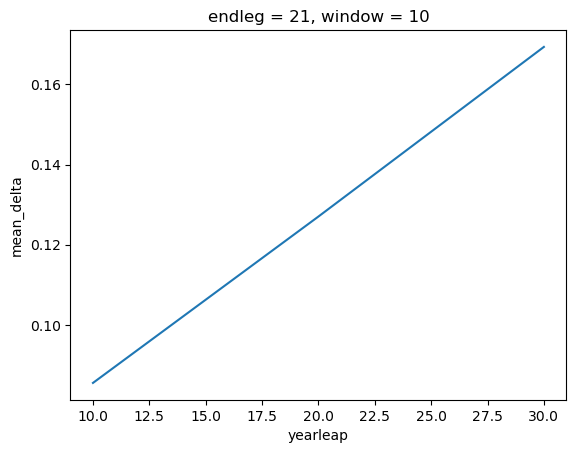

In [9]:
pdata.mean_delta.isel(window=0,endleg=0).plot()

In [1]:
from osprey.actions.forecaster import create_forecast_field

In [2]:
# create 1-year forecast in the future in full mode
ds1 = create_forecast_field(expname='TS00', varname='thetao', endleg=21, window=10, yearleap=1, mode='first', smoothing=False, debug=False)

2025-01-30 09:35:49,813 - INFO - Start/end year: 2000-2009
2025-01-30 09:35:49,820 - INFO - Time window: 10
2025-01-30 09:35:49,944 - INFO - Data available in the range 2000-2009.


KeyboardInterrupt: 

In [3]:
# create 10-year forecast in the future in full mode
ds = create_forecast_field(expname='TS00', varname='thetao', endleg=21, window=10, yearleap=10, mode='full', smoothing=False, debug=False)

2025-01-29 14:35:48,514 - INFO - Start/end year: 2000-2009
2025-01-29 14:35:48,516 - INFO - Time window: 10
2025-01-29 14:35:48,519 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2000-2000.nc
2025-01-29 14:35:48,520 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2001-2001.nc
2025-01-29 14:35:48,521 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2002-2002.nc
2025-01-29 14:35:48,522 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2003-2003.nc
2025-01-29 14:35:48,523 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2004-2004.nc
2025-01-29 14:35:48,524 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2005-2005.nc
2025-01-29 14:35:48,525 - INFO - Merging filename: /ec/res4/scratch/itas/ece4/TS00/output/nemo/TS00_oce_1m_T_2006-2006.nc
2025-01-29 14:35:48,526 - INFO - Mergi

In [1]:
# read the unperturbed field
from osprey.actions.reader import reader_nemo_field
ds0 = reader_nemo_field(expname='pi00', startyear=1990, endyear=2040, varname='thetao')

2025-01-30 14:06:51,540 - INFO - Data available in the range 1990-2040.


In [12]:
ds0_winter = ds0.sel(time=ds0.time.dt.month.isin([12, 1]))

In [25]:
# Seleziona solo dicembre e gennaio
ds0_winter = ds0.sel(time=ds0.time.dt.month.isin([12, 1]))

# Creiamo un identificatore per gli anni invernali:
# Dicembre rimane nell'anno corrente, Gennaio va nell'anno successivo
winter_year = xr.where(ds0_winter["time"].dt.month == 12, ds0_winter["time"].dt.year, ds0_winter["time"].dt.year + 1)

# Raggruppa per anno invernale e calcola la media
ds_winter_mean = ds0_winter.groupby(winter_year).mean(dim="time")

# Assegniamo il nuovo asse temporale: media tra dicembre e gennaio
time_mean = ds0_winter['time'].groupby(winter_year).mean(dim="time")

# Assegniamo il nuovo asse temporale mantenendo cftime
ds_winter_mean = ds_winter_mean.assign_coords(time=time_mean)

In [28]:
ds=ds0

# Seleziona solo dicembre e gennaio
ds_winter = ds.sel(time=ds.time.dt.month.isin([12, 1]))

# Creiamo una nuova variabile temporale per associare gennaio all'anno successivo
# Dicembre rimane nell'anno corrente, Gennaio nell'anno successivo
time_shifted = xr.where(ds_winter["time"].dt.month == 12, ds_winter["time"], ds_winter["time"] + np.timedelta64(1, 'Y'))

# Ora possiamo calcolare la media senza cambiare l'asse 'time'
# Raggruppa solo per coppie dicembre-gennaio
data_mean = (ds_winter["variabile"][:-1:2] + ds_winter["variabile"][1::2]) / 2

# Media sui tempi (media tra dicembre e gennaio)
time_mean = (time_shifted[:-1:2] + time_shifted[1::2]) / 2

# Creiamo il DataArray con il nuovo tempo medio, mantenendo l'asse 'time'
ds_winter_mean = xr.DataArray(data_mean, coords={"time": time_mean}, dims=["time"])


NameError: name 'np' is not defined

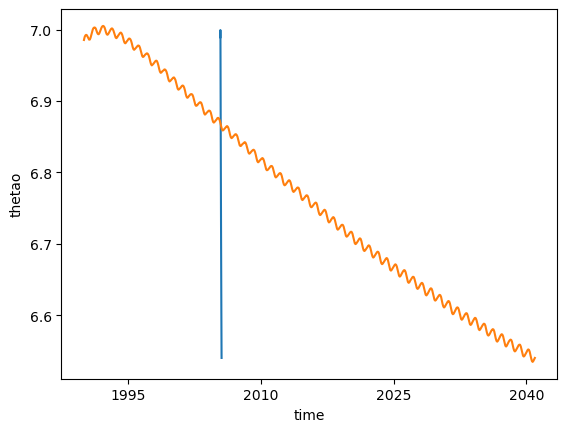

In [ ]:
from osprey.means.means import spacemean
ave_winter = spacemean(ds0_winter_mean, ndim='3D')
ave = spacemean(ds0, ndim='3D')
ave_winter.plot()
ave.plot()

In [5]:
from osprey.means.eof import performance_eofs, mean_performance_eofs
from osprey.utils import catalogue

info = catalogue.observables('nemo')['thetao']
delta, squared_delta, slope = performance_eofs(fdata=ds, udata=ds0, targetyear=2030, varname='thetao')
mean_delta, mean_squared_delta, mean_slope = mean_performance_eofs(delta, squared_delta, slope, info)

In [17]:
targetyear = 2030
start_date = f"{targetyear}0101"  # foreyear-1 o foreyear ???
end_date = f"{targetyear}0131"
udata = ds0.sel(time=slice(start_date, end_date))

In [19]:
ds

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 1, y: 148, x: 180, z: 31)
Coordinates:
  * time     (time) object 8B 2019-01-16 12:00:00
    lon      (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
    lat      (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
  * z        (z) float32 124B 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    thetao   (time, z, y, x) float64 7MB dask.array<chunksize=(1, 1, 148, 180), meta=np.ndarray>

In [12]:
targetyear = 2031
start_date = f"{targetyear-1}1231"  # foreyear-1 o foreyear ???
end_date = f"{targetyear}0131"
delta = ds['thetao'].isel(time=0) - ds0.sel(time=slice(start_date, end_date))
squared_delta = delta**2

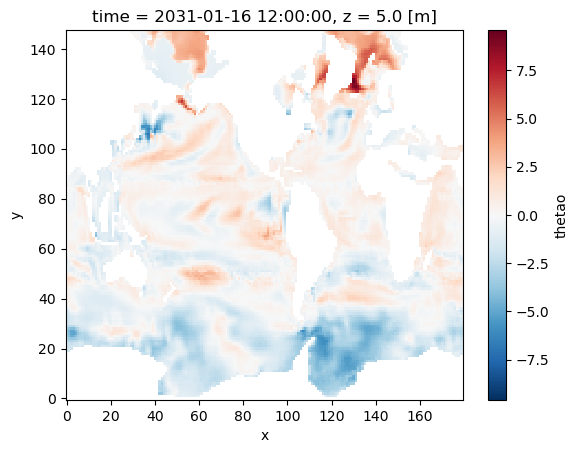

In [13]:
delta.isel(z=0,time=0).plot()

In [11]:
import numpy as np
fdata_rolled = ds0.rolling(time=12, center=True).mean()
time_diff = np.diff(fdata_rolled['time'].values).astype('timedelta64[D]').astype(float)
time_diff_da = xr.DataArray(time_diff, coords=[fdata_rolled['time'][1:]], dims=["time"])
time_diff_aligned, ds0_diff_aligned = xr.align(time_diff_da, fdata_rolled.diff(dim="time"), join='exact')
slopes = ds0_diff_aligned / time_diff_aligned

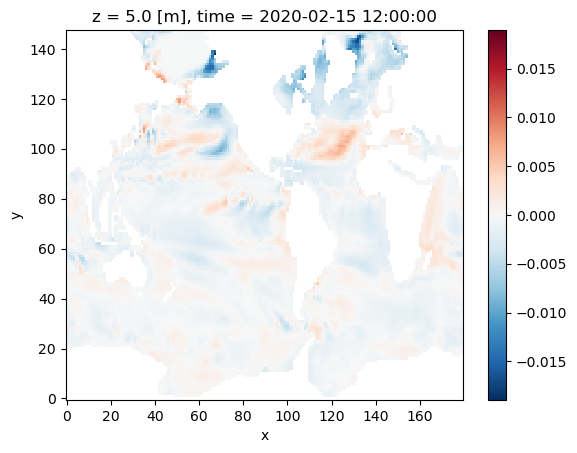

In [13]:
slopes.isel(time=360,z=0).plot()

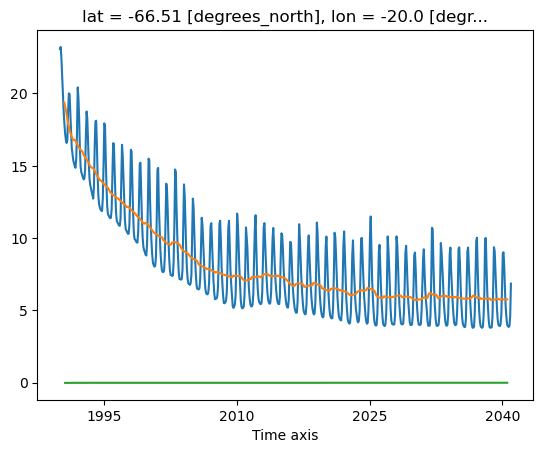

In [25]:
ds0.isel(z=0,x=130,y=20).plot()
fdata_rolled.isel(z=0,x=130,y=20).plot()
slopes.isel(z=0,x=130,y=20).plot()

In [6]:
import os
from osprey.utils.time import get_decimal_year
from osprey.means.eof import process_data
from osprey.utils import catalogue
info = catalogue.observables('nemo')['thetao']
filename = os.path.join("/ec/res4/scratch/itas/martini/TS00/021", f"thetao_series_00000.nc")
timeseries = xr.open_mfdataset(filename, use_cftime=True, preprocess=lambda data: process_data(data, ftype='series', dim=info['dim'], grid=info['grid']))
new_time = get_decimal_year(timeseries['time'].values)
timeseries['time'] = new_time
coeffs = timeseries.polyfit(dim='time', deg=1, skipna=True)
m, q = coeffs[f"thetao_polyfit_coefficients"].values
print(f"m={m}, q={q}")

m=-119.05976956553387, q=238660.359914224


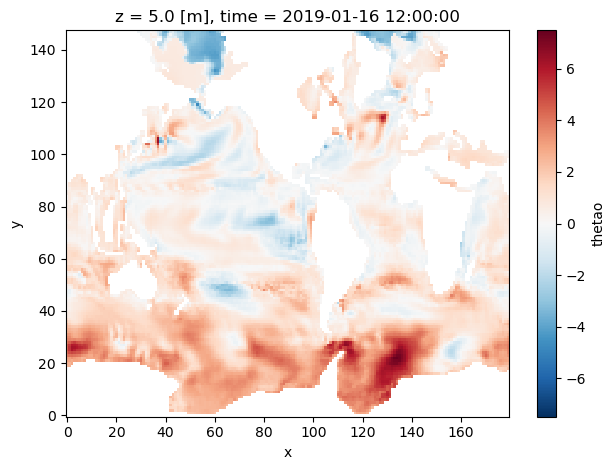

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=1)

# Plot ds forecast
field1 = ds['thetao'].isel(time=0, z=0)#.plot(ax=axes[0], vmin=-2.5, vmax=32)
#axes[0].set_title('Forecast Field')

# Plot ds0 ref
field2 = ds0.sel(time=slice('20190101', '20190131')).isel(z=0)#.plot(ax=axes[1], vmin=-2.5, vmax=32)
#axes[1].set_title('Unperturbed Field')

delta =field2-field1
delta.plot()

plt.tight_layout()
plt.show()

In [19]:
ds0

<xarray.DataArray 'thetao' (time: 612, z: 31, y: 148, x: 180)> Size: 2GB
dask.array<concatenate, shape=(612, 31, 148, 180), dtype=float32, chunksize=(12, 31, 148, 180), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
    lon      (y, x) float32 107kB dask.array<chunksize=(148, 180), meta=np.ndarray>
  * z        (z) float32 124B 5.0 15.0 25.0 35.01 ... 4.25e+03 4.75e+03 5.25e+03
  * time     (time) object 5kB 1990-01-16 12:00:00 ... 2040-12-16 12:00:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  5400 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5400 s)

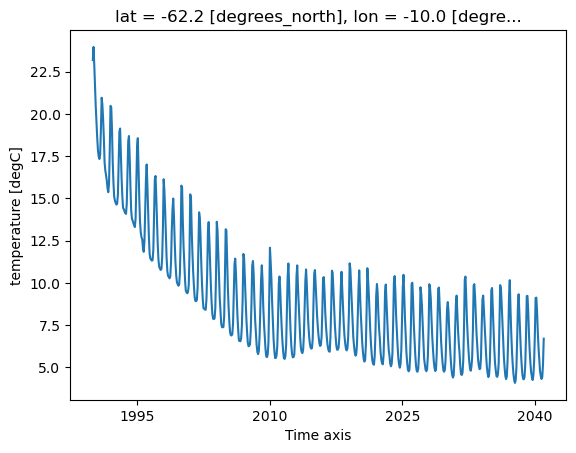

In [30]:
from osprey.means.means import spacemean


ds0.isel(x=135,y=25,z=0).plot()
y = dss1.isel(x=135,y=25,z=0)


In [31]:
y

<xarray.Dataset> Size: 28B
Dimensions:  (time: 1)
Coordinates:
  * time     (time) object 8B 2010-01-16 12:00:00
    lon      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lat      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    z        float32 4B 5.0
Data variables:
    thetao   (time) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>

In [27]:
ds0.isel(x=50,y=140,z=0).sel(time='20190116').values

array([-1.8582087], dtype=float32)

In [32]:
ds['thetao'].isel(x=135,y=25,z=0).values

array([4.26187967])

In [ ]:
ave[].plot()

Text(0.5, 1.0, 'x,y,z = [130, 20, 0]')

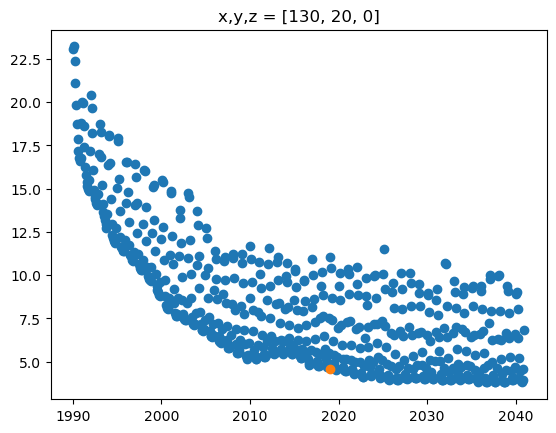

In [9]:
# plot the forecast and the unpertubed on a random spot (x,y,z)

import random
from osprey.utils.time import get_decimal_year

x0=random.randint(0, 179)
y0=random.randint(0, 147)
z0=random.randint(0, 30)

x0=130
y0=20
z0=0

yr = ds0.isel(z=z0,y=y0,x=x0).values
xr = get_decimal_year(ds0['time'].values)

xx = get_decimal_year(ds['time'].values)
yy = ds['thetao'].isel(time=0,z=z0,y=y0,x=x0).values

plt.scatter(x=xr, y=yr)
plt.scatter(x=xx, y=yy)
plt.title('x,y,z = {}'.format([x0,y0,z0]))

In [6]:
# compute the difference between the forecast and the unperturbed field
delta = ds['thetao'].isel(time=0)-ds0.sel(time=slice('20190101', '20190131'))
sqerr = delta**2
#sqerr.isel(z=0).plot(cmap=plt.cm.coolwarm, vmin=0, vmax=40)

Text(0, 0.5, 'PDF')

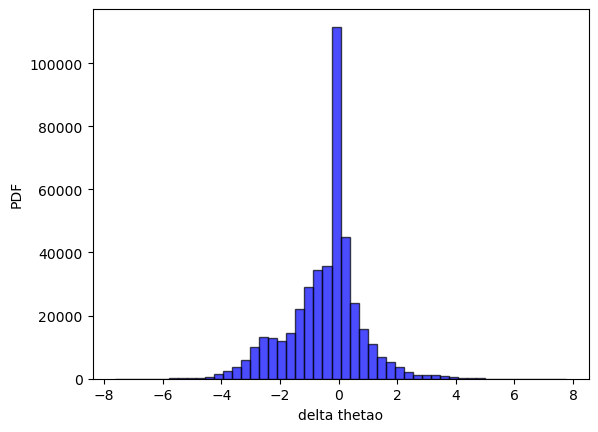

In [39]:
# histogram of the difference
plt.hist(delta.values.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('delta thetao')
plt.ylabel('PDF')

Text(0, 0.5, 'PDF')

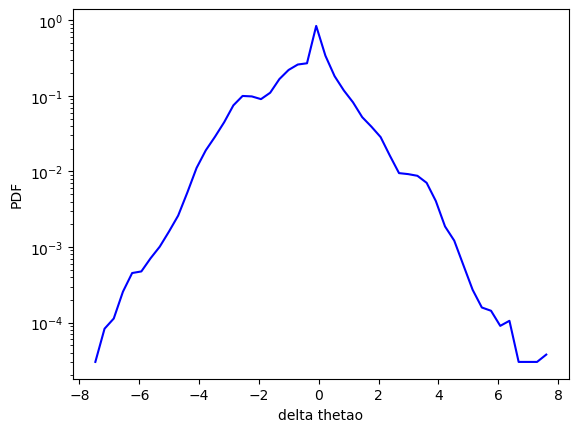

In [40]:
# histrogram in log scale

import numpy as np

flattened_delta = delta.values.flatten()
filtered_delta = flattened_delta[~np.isnan(flattened_delta) & ~np.isinf(flattened_delta)]
density, bins = np.histogram(filtered_delta, bins=50, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, density, label="full EOFs", color="blue")
plt.yscale('log')
plt.xlabel('delta thetao')
plt.ylabel('PDF')

Text(0, 0.5, 'PDF')

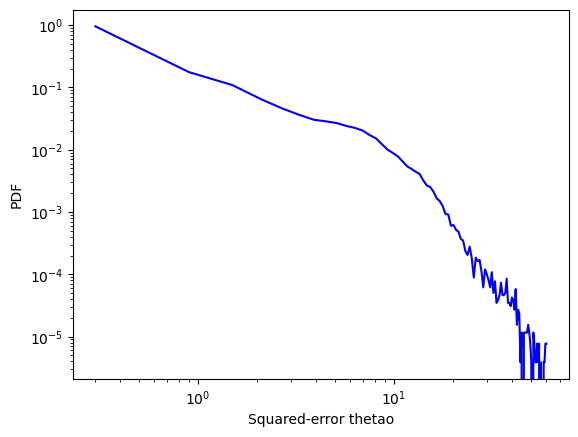

In [44]:
# histogram of squared error

flattened_delta = sqerr.values.flatten()
filtered_delta = flattened_delta[~np.isnan(flattened_delta) & ~np.isinf(flattened_delta)]
density, bins = np.histogram(filtered_delta, bins=100, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.plot(bin_centers, density, label="full EOFs", color="blue")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Squared-error thetao')
plt.ylabel('PDF')

Text(0, 0.5, 'PDF')

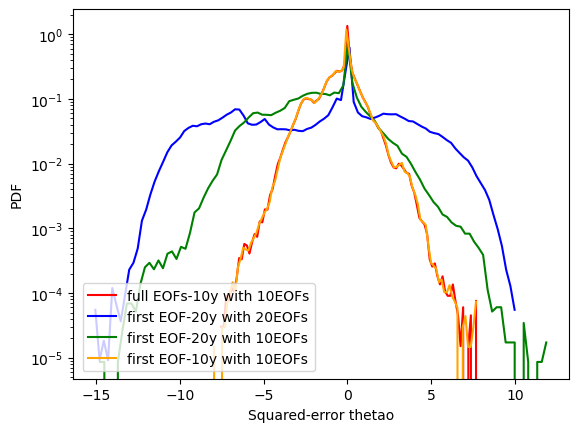

In [92]:
# histogram of squared error

flattened_delta = delta.values.flatten()
filtered_delta = flattened_delta[~np.isnan(flattened_delta) & ~np.isinf(flattened_delta)]
density, bins = np.histogram(filtered_delta, bins=100, density=True)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

flattened_delta1 = delta1.values.flatten()
filtered_delta1 = flattened_delta1[~np.isnan(flattened_delta1) & ~np.isinf(flattened_delta1)]
density1, bins1 = np.histogram(filtered_delta1, bins=100, density=True)
bin_centers1 = 0.5 * (bins1[1:] + bins1[:-1])

flattened_delta2 = delta2.values.flatten()
filtered_delta2 = flattened_delta2[~np.isnan(flattened_delta2) & ~np.isinf(flattened_delta2)]
density2, bins2 = np.histogram(filtered_delta2, bins=100, density=True)
bin_centers2 = 0.5 * (bins2[1:] + bins2[:-1])

flattened_delta3 = delta3.values.flatten()
filtered_delta3 = flattened_delta3[~np.isnan(flattened_delta3) & ~np.isinf(flattened_delta3)]
density3, bins3 = np.histogram(filtered_delta3, bins=100, density=True)
bin_centers3 = 0.5 * (bins3[1:] + bins3[:-1])

plt.plot(bin_centers, density, label="full EOFs-10y with 10EOFs", color="red")
plt.plot(bin_centers1, density1, label="first EOF-20y with 20EOFs", color="blue")
plt.plot(bin_centers2, density2, label="first EOF-20y with 10EOFs", color="green")
plt.plot(bin_centers3, density3, label="first EOF-10y with 10EOFs", color="orange")

plt.legend(
    bbox_to_anchor=(0.02, 0.02),  # x, y coordinates for legend placement
    loc='lower left',         # Location of the legend relative to bbox_to_anchor
    borderaxespad=0           # Padding between the legend and the plot
)

plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Squared-error thetao')
plt.ylabel('PDF')

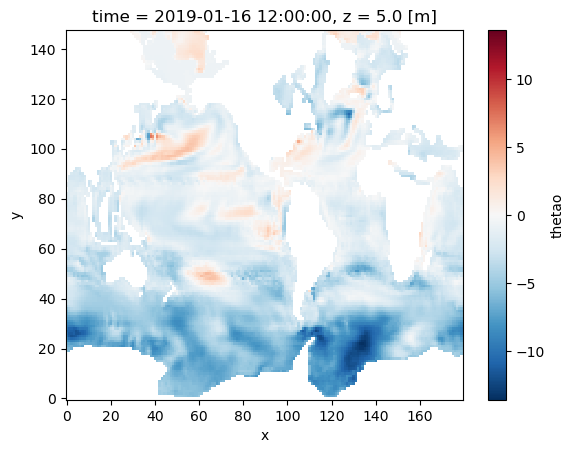

In [84]:
delta2=ds2['thetao'].isel(time=0)-ds0.sel(time=slice('20190101', '20190131'))
sqerr2 = delta2**2
delta2.isel(z=0).plot()

In [18]:
ds0_m = ds0.rolling(time=12, center=True).mean()

In [16]:
from osprey.means.means import spacemean
ave = spacemean(ds0_m, '3D')

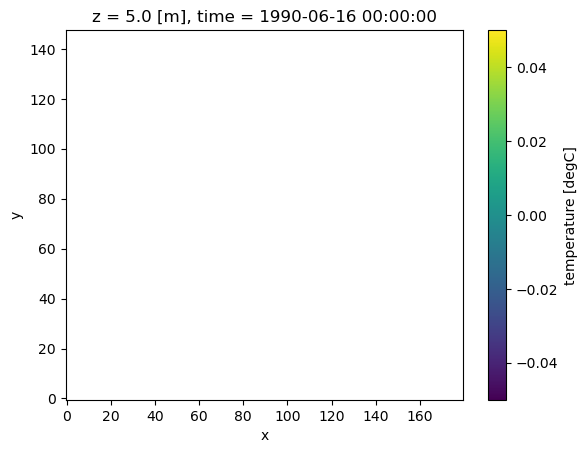

In [ ]:
ds0_m.isel(time=0,z=0).plot()

In [11]:
import numpy as np

# Align the time dimension for broadcasting
time_diff = np.diff(ds0_m['time'].values).astype('timedelta64[D]').astype(float)
time_diff_da = xr.DataArray(time_diff, coords=[ds0_m['time'][1:]], dims=["time"])
time_diff_aligned, ds0_diff_aligned = xr.align(time_diff_da, ds0_m.diff(dim="time"), join='exact')

# Calculate the slopes
slopes = ds0_diff_aligned / time_diff_aligned

In [12]:
from osprey.means.means import timemean
slopes_interval = slopes.sel(time=slice('2000-01-01', '2009-12-31'))
oneslope=timemean(slopes_interval)

Text(0, 0.5, 'Delta thetao')

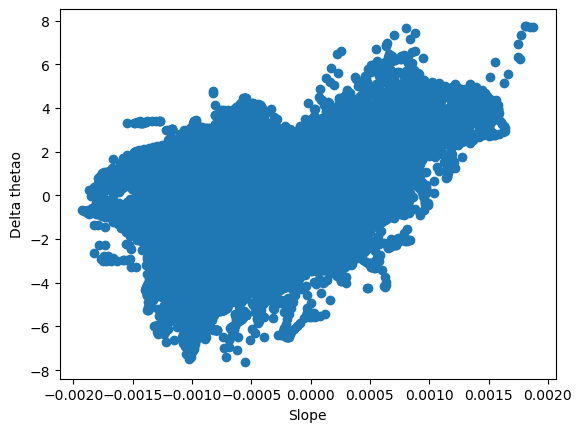

In [13]:
oneslope_flat = oneslope.values.flatten()
delta_flat = delta.values.flatten()
plt.plot(oneslope_flat, delta_flat, 'o')
plt.xlabel('Slope')
plt.ylabel('Delta thetao')

In [11]:
from osprey.means.means import spacemean

ave_slope = spacemean(data=slopes, ndim='3D')

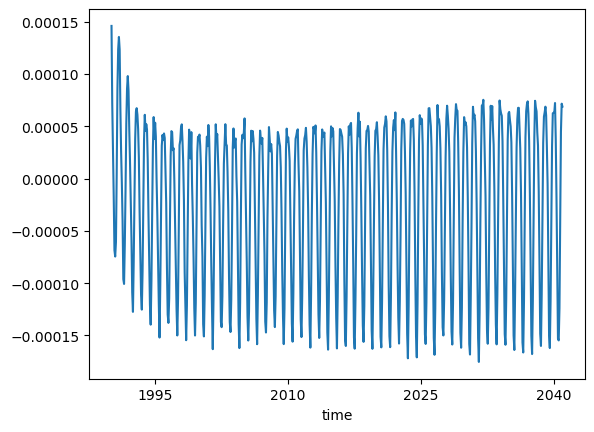

In [14]:
ave_slope.plot()

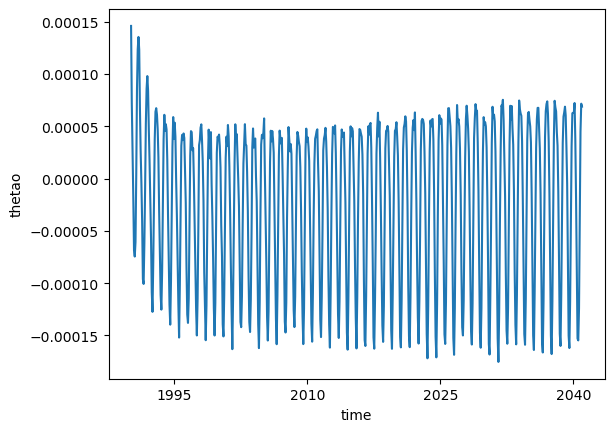

In [19]:
ave = spacemean(data=ds0, ndim='3D')
time_diff = np.diff(ave['time'].values).astype('timedelta64[D]').astype(float)
tslopes = ave.diff(dim='time') / time_diff
tslopes.plot()

In [30]:
### add moving average

from osprey.means.means import movave

mave = movave(ave, 12)
mslopes = movave(tslopes, 12)

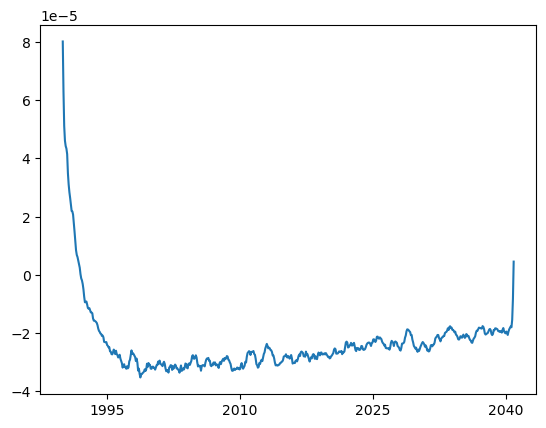

In [34]:
#plt.plot(ds0['time'].values[:len(mave)], mave)
plt.plot(ds0['time'].values[:len(mslopes)], mslopes)